In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

data = pd.read_csv('homicidios.csv')

In [2]:
data[['lat', 'long']].head(3)

,lat,long
0,-34.687570,-58.475340
1,-34.669777,-58.508775
2,-34.631894,-58.390403


In [3]:
data[['lat', 'long']].describe()

,lat,long
count,687.000000,687.000000
mean,-34.619668,-58.441428
std,0.035199,0.045941
min,-34.705250,-58.529942
25%,-34.643608,-58.475973
50%,-34.622849,-58.444024
75%,-34.597107,-58.401944
max,-34.534654,-58.356082


In [4]:
# Duplicated locations

data[data[['lat', 'long']].duplicated()].sort_values(by='lat').head()

# 5 happened in the exact same location (lat & long)

,Unnamed: 0,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),long,lat,PARTICIPANTES,VICTIMA,ACUSADO,FECHA-HORA
557,565,2020-0045,1,2020-10-19,2020,10,19,03:00:00,3,"PAZ, GRAL. AV. Y 27 DE FEBRERO AV.",...,27 DE FEBRERO AV.,"PAZ, GRAL. AV. y 27 DE FEBRERO AV.",8,Point (100077.95205948 91571.23307293),-58.462450,-34.705250,AUTO-CARGAS,AUTO,CARGAS,2020-10-19 03:00:00
568,576,2020-0056,1,2020-11-21,2020,11,21,13:00:00,13,"PAZ, GRAL. AV. Y DOCTOR RAMON CARRILLO",...,"ROCA, CNEL. AV.","PAZ, GRAL. AV. y ROCA, CNEL. AV.",8,Point (99327.01838497 92326.91130631),-58.470646,-34.698438,MOTO-CARGAS,MOTO,CARGAS,2020-11-21 13:00:00
254,259,2017-0144,1,2017-11-26,2017,11,26,06:45:00,6,AV. CNEL. ROCA Y COLECTORA AV. GRAL. PAZ,...,"PAZ, GRAL. AV.","ROCA, CNEL. AV. y PAZ, GRAL. AV.",8,Point (99327.01838497 92326.91130631),-58.470646,-34.698438,AUTO-OBJETO FIJO,AUTO,OBJETO FIJO,2017-11-26 06:45:00
437,443,2019-0026,1,2019-03-28,2019,3,28,07:32:00,7,"FERNANDEZ DE LA CRUZ, F. , GRAL. AV. Y LARRAZABAL",...,"PAZ, GRAL. AV.","FERNANDEZ DE LA CRUZ, F., GRAL. AV. y PAZ, GRA...",8,Point (98491.08733048 93092.87943671),-58.479768,-34.691532,PEATON-PASAJEROS,PEATON,PASAJEROS,2019-03-28 07:32:00
440,446,2019-0029,1,2019-04-07,2019,4,7,10:15:00,10,"FERNANDEZ DE LA CRUZ, F. , GRAL. AV. Y LACARRA...",...,"PAZ, GRAL. AV.","FERNANDEZ DE LA CRUZ, F., GRAL. AV. y PAZ, GRA...",8,Point (98491.08733048 93092.87943671),-58.479768,-34.691532,MOTO-OBJETO FIJO,MOTO,OBJETO FIJO,2019-04-07 10:15:00


In [5]:
# Get maps centers around the mean of 'lat' and 'long'

map_center = [data['lat'].mean(), data['long'].mean()]

# Create default settings for later maps

general_map_settings = {
    'location': map_center,
    'zoom_start': 12,
    'tiles': 'cartodb positron'
}

# Create a Folium Map object with the specified settings

map = folium.Map(**general_map_settings)

In [6]:
# Showing 'comunas' according to GeoJson file
# 

geo_json_data_path = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/comunas/comunas.geojson"

# geo_json_data_path = "barrios_CABA_geoJson.json" # Same info has been downloaded and available for local upload

folium.GeoJson(
    geo_json_data_path,
    style_function=lambda feature: {
        'fillColor': 'blue',  
        'color': 'black',      
        'weight': 2,           
        'fillOpacity': 0.2
    },
    tooltip=folium.GeoJsonTooltip(
                                    fields=['COMUNAS'],
                                    labels=True,
                                    sticky=True),
    zoom_on_click=True

).add_to(map)

map

In [7]:
# Setting criteria column to plot/map
grouped_data = data.groupby('VICTIMA')

# Define a dictionary with custom icons and colors for each 'VICTIMA' value
icon_colors = {
    'AUTO': ('glyphicon-road', 'green'),
    'BICICLETA': ('glyphicon-transfer', 'blue'),
    'CARGAS': ('glyphicon-dashboard', 'red'),
    'MOTO': ('glyphicon-remove', 'orange'),
    'MOVIL': ('glyphicon-cutlery', 'purple'),
    'OBJETO FIJO': ('glyphicon-cog', 'darkpurple'),
    'PASAJEROS': ('glyphicon-trash', 'lightblue'),
    'PEATON': ('glyphicon-heart', 'cadetblue'),
    'PEATON_MOTO': ('glyphicon-home', 'gray'),
    'SD': ('glyphicon-road', 'black')
}


# Iterate over each group
for group_value, group_data in grouped_data:
    # Create a separate FeatureGroup for each group_value

    fg = folium.FeatureGroup(name=group_value).add_to(map)
    
    # Get the icon and color for the current group_value
    #  If the key is not present in the dictionary, it returns a default value, which is a tuple ('glyphicon-info-sign', 'gray').

    # icon, color = ...: This part unpacks the result of the get method into two variables, icon and color.
    # If group_value is present in icon_colors, it gets the corresponding values for icon and color.
    # If not, it uses the default values ('glyphicon-info-sign', 'gray').

    icon, color = icon_colors.get(group_value, ('glyphicon-info-sign', 'gray'))
    
    # Add markers with custom icons and colors
    for index, row in group_data.iterrows():
        folium.Marker(
            location=[row['lat'], row['long']],
            popup=group_value,
            icon=folium.Icon(color=color, icon=icon)
        ).add_to(fg)

# Add LayerControl to the map

folium.LayerControl().add_to(map)

map



In [8]:
heat_map = folium.Map(**general_map_settings)

heat_data = list(zip(data['lat'], data['long']))
folium.GeoJson(geo_json_data_path, name='Comunas Layer', zoom_on_click=True).add_to(heat_map)
folium.plugins.HeatMap(
    heat_data,
    radius=20,
    blur=15,
    gradient={0.2: 'blue', 0.5: 'lime', 0.8: 'red'}
).add_to(heat_map)

heat_map

### From now on, i'll center on insights that come from data.

In [9]:
from pyspark.sql import SparkSession

# Create a Spark Session

spark = SparkSession.builder \
    .appName("LightweightSparkSession") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.instances", "2") \
    .config("spark.driver.memory", "512m") \
    .config("spark.driver.cores", "1") \
    .config("spark.default.parallelism", "4") \
    .getOrCreate()

spark_hechos = spark.read.csv("homicidios_hechos.csv", header=True)
spark_victimas = spark.read.csv("homicidios_victimas.csv", header=True)

In [10]:
spark_hechos.show(5)

+---+---------+----------+----------+----+---+---+--------+---+--------------------+-------------+----------------+------+--------------------+---------------------+------+------------+------------+--------------+-------+---------+-------------------+
|_c0|       ID|N_VICTIMAS|     FECHA|AAAA| MM| DD|    HORA| HH|     LUGAR_DEL_HECHO|TIPO_DE_CALLE|           Calle|Altura|               Cruce|Dirección Normalizada|COMUNA|        long|         lat| PARTICIPANTES|VICTIMA|  ACUSADO|         FECHA-HORA|
+---+---------+----------+----------+----+---+---+--------+---+--------------------+-------------+----------------+------+--------------------+---------------------+------+------------+------------+--------------+-------+---------+-------------------+
|  0|2016-0001|         1|2016-01-01|2016|  1|  1|04:00:00|  4|AV PIEDRA BUENA Y...|      AVENIDA|PIEDRA BUENA AV.|  NULL|FERNANDEZ DE LA C...| PIEDRA BUENA AV. ...|     8|-58.47533969|-34.68757022|     MOTO-AUTO|   MOTO|     AUTO|2016-01-01 04

In [11]:
spark_victimas.show(5)

+---+---------+----------+----+---+---+---------+-------+---------+----+-------------------+
|_c0| ID_hecho|     FECHA|AAAA| MM| DD|      ROL|VICTIMA|     SEXO|EDAD|FECHA_FALLECIMIENTO|
+---+---------+----------+----+---+---+---------+-------+---------+----+-------------------+
|  0|2016-0001|2016-01-01|2016|  1|  1|CONDUCTOR|   MOTO|MASCULINO|  19|2016-01-01 00:00:00|
|  1|2016-0002|2016-01-02|2016|  1|  2|CONDUCTOR|   AUTO|MASCULINO|  70|2016-01-02 00:00:00|
|  2|2016-0003|2016-01-03|2016|  1|  3|CONDUCTOR|   MOTO|MASCULINO|  30|2016-01-03 00:00:00|
|  3|2016-0004|2016-01-10|2016|  1| 10|CONDUCTOR|   MOTO|MASCULINO|  18|               NULL|
|  4|2016-0005|2016-01-21|2016|  1| 21|CONDUCTOR|   MOTO|MASCULINO|  29|2016-02-01 00:00:00|
+---+---------+----------+----+---+---+---------+-------+---------+----+-------------------+
only showing top 5 rows



In [12]:
# Create temporary tables

spark_hechos.createOrReplaceTempView("hechos_sql")
spark_victimas.createOrReplaceTempView("victimas_sql")

In [13]:
# Query 1: How many people died by year in street accidents.

sql_query1 = """
                SELECT
                        spk_h.AAAA as year,
                        SUM(spk_h.N_VICTIMAS) as total_victims
                FROM hechos_sql as spk_h
                JOIN victimas_sql as spk_v on spk_h.ID = spk_v.ID_hecho
                GROUP BY year
                ORDER BY year
        """
result1 = spark.sql(sql_query1)
result1_pandas = result1.toPandas()
result1.show()

+----+-------------+
|year|total_victims|
+----+-------------+
|2016|        147.0|
|2017|        155.0|
|2018|        160.0|
|2019|        105.0|
|2020|         86.0|
|2021|         96.0|
+----+-------------+



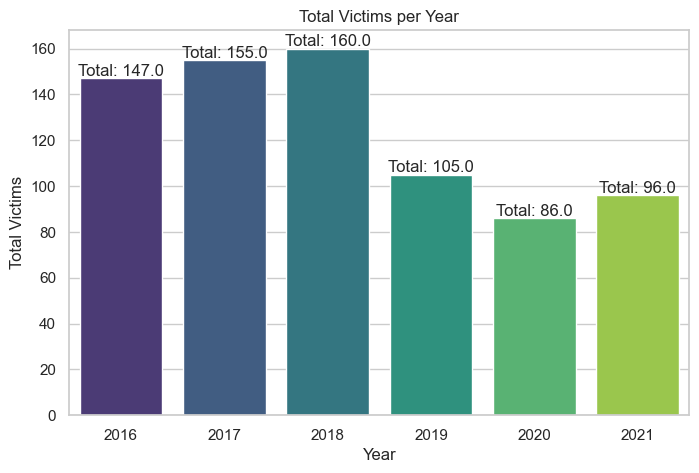

In [14]:
# Plot Query 1

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

sns.barplot(
            x='year',
            y='total_victims',
            data=result1_pandas,
            palette='viridis',
            errorbar=None)

# Calculate and annotate the total values on top of each bar
totals = result1_pandas.groupby('year')['total_victims'].sum().reset_index()

for i, total in enumerate(totals['total_victims']):
    plt.text(i, total + 1, f'Total: {total}', ha='center')

plt.xlabel('Year')
plt.ylabel('Total Victims')
plt.title('Total Victims per Year')
plt.show()


In [15]:
# Query 2: How many people died by year and comuna in street accidents.

sql_query2 = """
                SELECT
                        COMUNA as comuna,
                        spk_h.AAAA as year,
                        SUM(spk_h.N_VICTIMAS) as total_victimas
                FROM hechos_sql as spk_h
                JOIN victimas_sql as spk_v on spk_h.ID = spk_v.ID_hecho
                GROUP BY year, comuna
                ORDER BY year, CAST(comuna AS INT)
                """
result2 = spark.sql(sql_query2)
result2_pandas = result2.toPandas()
result2.show(5)

+------+----+--------------+
|comuna|year|total_victimas|
+------+----+--------------+
|     1|2016|          22.0|
|     2|2016|           1.0|
|     3|2016|           8.0|
|     4|2016|          15.0|
|     5|2016|           3.0|
+------+----+--------------+
only showing top 5 rows



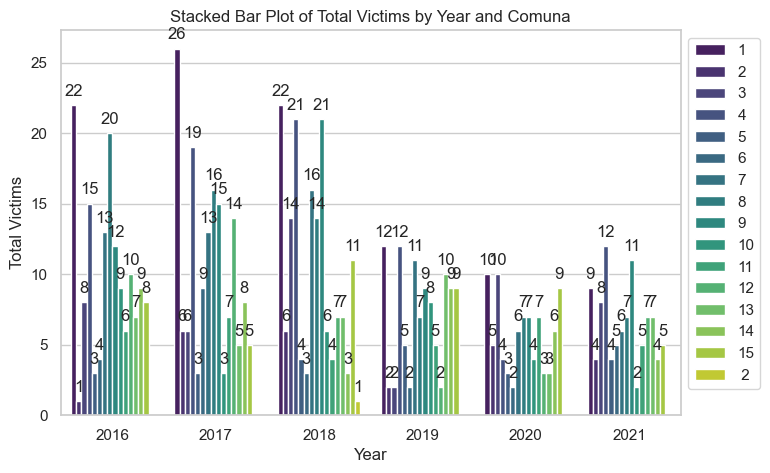

In [16]:
# Plot Query 2

sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

ax = sns.barplot(x='year',
                 y='total_victimas',
                 hue='comuna',
                 data=result2_pandas,
                 palette='viridis',
                 errorbar=None)

# Add values on top of each stacked bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')


plt.xlabel('Year')
plt.ylabel('Total Victims')
plt.title('Stacked Bar Plot of Total Victims by Year and Comuna')

# Display the legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


In [17]:
# Query 3: How many people died by type of rol (victim was riding). Add percentage.

sql_query3 = """
                
                SELECT
                        ROL as rol,
                        COUNT(victimas_sql.VICTIMA) as total_victimas,
                        round(COUNT(victimas_sql.VICTIMA)/SUM(COUNT(victimas_sql.VICTIMA)) OVER ()*100, 2) as percentage
                
                FROM victimas_sql
                GROUP BY rol
                ORDER BY percentage;
        """
result3 = spark.sql(sql_query3)
result3_pandas = result3.toPandas()
result3.show()

+--------------------+--------------+----------+
|                 rol|total_victimas|percentage|
+--------------------+--------------+----------+
|                NULL|             3|      0.42|
|            CICLISTA|            29|       4.1|
|PASAJERO_ACOMPAÑANTE|            79|     11.16|
|              PEATON|           267|     37.71|
|           CONDUCTOR|           330|     46.61|
+--------------------+--------------+----------+



Text(0.5, 1.0, 'Distribution of Victims by Role')

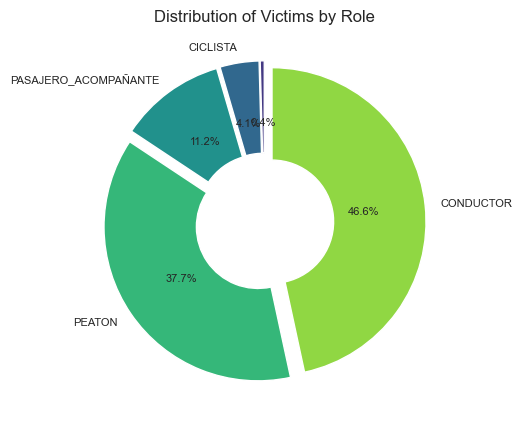

In [18]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))

# Define the explode values to create space between sectors
explode = (0.05, 0.05, 0.05, 0.05, 0.05)

plt.pie(result3_pandas['total_victimas'],
        labels=result3_pandas['rol'],
        autopct='%1.1f%%',
        startangle=90,
        colors=sns.color_palette("viridis", len(result3_pandas)),
        textprops={'fontsize': 8},
        explode=explode,
        wedgeprops=dict(width=0.6))
# Set the title
plt.title('Distribution of Victims by Role')

In [19]:
# Query 4: How many people died by type of street. Add percentage.

sql_query4 = """
                SELECT
                        TIPO_DE_CALLE as tipo_de_calle,
                        SUM(N_VICTIMAS) as total_victimas,
                        round(SUM(hechos_sql.N_VICTIMAS)/SUM(SUM(hechos_sql.N_VICTIMAS)) OVER ()*100, 2) as percentage
                FROM hechos_sql
                GROUP BY tipo_de_calle
                ORDER BY percentage;
        """
result4 = spark.sql(sql_query4)
result4.show()

+-------------+--------------+----------+
|tipo_de_calle|total_victimas|percentage|
+-------------+--------------+----------+
|    AUTOPISTA|          60.0|      8.49|
|     GRAL PAZ|          68.0|      9.62|
|        CALLE|         137.0|     19.38|
|      AVENIDA|         442.0|     62.52|
+-------------+--------------+----------+



In [20]:
# Query 5: Total male or female victims by vehicle. Add percentage

sql_query5 = """
                
                SELECT
                VICTIMA as Vehicle,
                SUM(CASE WHEN SEXO = 'MASCULINO' THEN 1 ELSE 0 END) as male_count,
                SUM(CASE WHEN SEXO = 'FEMENINO' THEN 1 ELSE 0 END) as female_count,
                round(SUM(CASE WHEN SEXO = 'MASCULINO' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2) as male_percentage,
                round(SUM(CASE WHEN SEXO = 'FEMENINO' THEN 1 ELSE 0 END) * 100.0 / COUNT(*),2) as female_percentage
                FROM victimas_sql
                GROUP BY VICTIMA;

        """
result5 = spark.sql(sql_query5)
result5.show()

+---------+----------+------------+---------------+-----------------+
|  Vehicle|male_count|female_count|male_percentage|female_percentage|
+---------+----------+------------+---------------+-----------------+
|   CARGAS|         7|           0|         100.00|             0.00|
|BICICLETA|        21|           8|          72.41|            27.59|
|PASAJEROS|         2|           3|          40.00|            60.00|
|     NULL|         6|           1|          66.67|            11.11|
|     AUTO|        79|          15|          84.04|            15.96|
|     MOTO|       264|          36|          87.13|            11.88|
|    MOVIL|         3|           0|         100.00|             0.00|
|   PEATON|       163|         103|          61.05|            38.58|
+---------+----------+------------+---------------+-----------------+

